# Submission Information:

### Team Member 1:
* UNI:  WL2522
* Name:  Wilson Lui

### Team Member 2 [optional]:
* UNI:  
* Name:

# Step0 - Import Libraries, Load Data [0 points]

This is the basic step where you can load the data and create train and test sets for internal validation as per your convinience.

([<matplotlib.axis.YTick at 0xbf01780>,
 <a list of 19 Text yticklabel objects>)

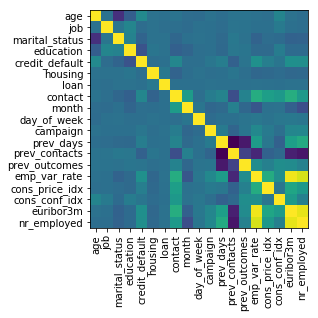

In [3]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import scale

data = pd.read_csv('data\data.csv')

#Get summary statistics on the data
#Remove the "duration" feature to avoid getting overoptimistic results

data = data.drop('duration', 1)
data.describe()

#Separate the categorical features from the numerical ones
#Encode category and response variable strings to integers

num = ['age', 'campaign', 'prev_days', 'prev_contacts', 'emp_var_rate',
       'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed']

cat = ['job', 'marital_status', 'education', 'credit_default', 'housing',
       'loan', 'contact', 'month', 'day_of_week', 'prev_outcomes']

enc_data = data.copy()

le = LabelEncoder()

for col in cat:
    levels = enc_data[col].unique()
    le.fit(levels)
    enc_data[col] = le.transform(enc_data[col])

#Separate the features from the response variable

levels = enc_data['subscribed'].unique()
le.fit(levels)
enc_data['subscribed'] = le.transform(enc_data['subscribed'])

X = enc_data.iloc[:,:-1]
y = enc_data.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y)

X_train_scaled = scale(X_train)

cov = np.cov(X_train_scaled, rowvar = False)
plt.imshow(cov, cmap='viridis', interpolation='nearest')
plt.xticks(range(len(list(X_train))), list(X_train), rotation = 'vertical')
plt.yticks(range(len(list(X_train))), list(X_train))


# Step1 - Exploration and Preparation [10 points]

In this step, we expect you to look into the data and try to understand it before modeling. This understanding may lead to some basic data preparation steps which are common across the two model sets required.

Counter({'admin.': 8342, 'blue-collar': 7408, 'technician': 5371, 'services': 3168, 'management': 2340, 'retired': 1390, 'entrepreneur': 1198, 'self-employed': 1140, 'housemaid': 827, 'unemployed': 797, 'student': 708, 'unknown': 261})


([<matplotlib.axis.XTick at 0xb1e3160>,
 <a list of 12 Text xticklabel objects>)

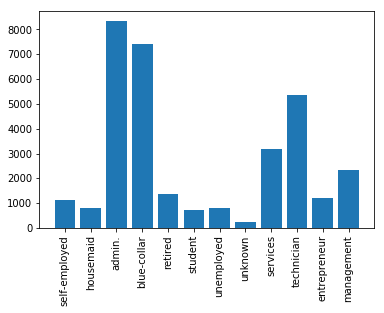

In [3]:
#Examine the distribution of job categories

job_count = Counter(data['job'])
print(job_count)
plt.bar(range(len(job_count)), job_count.values(), align='center')
plt.xticks(range(len(job_count)), list(job_count.keys()), rotation='vertical')


Counter({'married': 19955, 'single': 9256, 'divorced': 3676, 'unknown': 63})


([<matplotlib.axis.XTick at 0xb400588>,
 <a list of 4 Text xticklabel objects>)

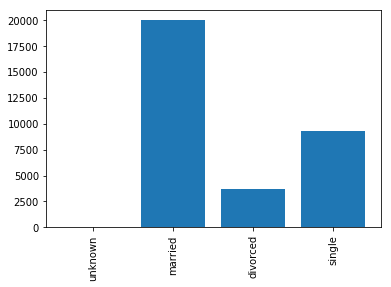

In [4]:
#Examine the distribution of marital statuses

marital_count = Counter(data['marital_status'])
print(marital_count)
plt.bar(range(len(marital_count)), marital_count.values(), align='center')
plt.xticks(range(len(marital_count)), list(marital_count.keys()), rotation='vertical')


Counter({'university.degree': 9760, 'high.school': 7580, 'basic.9y': 4889, 'professional.course': 4154, 'basic.4y': 3313, 'basic.6y': 1846, 'unknown': 1394, 'illiterate': 14})


([<matplotlib.axis.XTick at 0xb41ce10>,
 <a list of 8 Text xticklabel objects>)

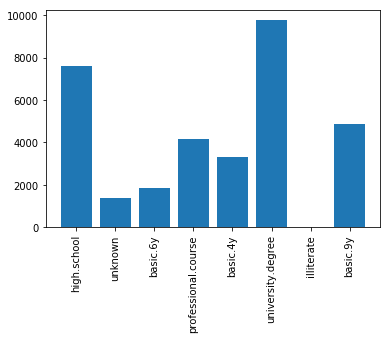

In [5]:
#Examine the distribution of education levels

education_count = Counter(data['education'])
print(education_count)
plt.bar(range(len(education_count)), education_count.values(), align='center')

plt.xticks(range(len(education_count)), list(education_count.keys()), rotation='vertical')

Counter({'no': 26059, 'unknown': 6888, 'yes': 3})
Counter({'yes': 17176, 'no': 14974, 'unknown': 800})
Counter({'no': 27179, 'yes': 4971, 'unknown': 800})
Counter({'cellular': 20902, 'telephone': 12048})


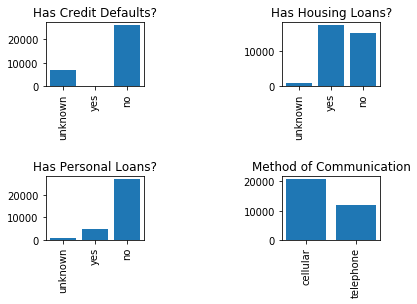

In [6]:
#Examine distribution of binary variables

default_count = Counter(data['credit_default'])
housing_count = Counter(data['housing'])
loan_count = Counter(data['loan'])
contact_count = Counter(data['contact'])
print(default_count)
print(housing_count)
print(loan_count)
print(contact_count)


ax1 = plt.subplot('331')
plt.bar(range(len(default_count)), default_count.values(), align='center')
plt.xticks(range(len(default_count)), list(default_count.keys()), rotation='vertical')
ax1.set_title('Has Credit Defaults?')

ax2 = plt.subplot('333')
plt.bar(range(len(housing_count)), housing_count.values(), align='center')
plt.xticks(range(len(housing_count)), list(housing_count.keys()), rotation='vertical')
ax2.set_title('Has Housing Loans?')

ax3 = plt.subplot('337')
plt.bar(range(len(loan_count)), loan_count.values(), align='center')
plt.xticks(range(len(loan_count)), list(loan_count.keys()), rotation='vertical')
ax3.set_title('Has Personal Loans?')

ax4 = plt.subplot('339')
plt.bar(range(len(contact_count)), contact_count.values(), align='center')
plt.xticks(range(len(contact_count)), list(contact_count), rotation='vertical')
ax4.set_title('Method of Communication')

ValueError: could not convert string to float: 'no'

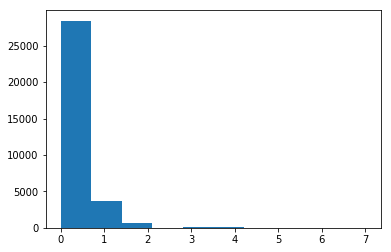

In [64]:
plt.hist(data['prev_contacts'])



# Step2 - ModelSet1 [35 points]

In this step, we expect you to perform the following steps relevant to the models you choose for set1:

* feature engineering
* validation
* feature selection
* final model selection

You may select up to 5 models in this step for the purpose of final ensemble. Any classification algorithm covered in class apart from tree-based models can be tested here.

In [3]:
#write code below, you can make multiple cells

# Step3 - ModelSet2 [35 points]

In this step, we expect you to perform the following steps relevant to the models you choose for set2:

* feature engineering
* validation
* feature selection
* final model selection

You may select up to 5 models in this step for the purpose of final ensemble. We encourage you to try decition tree, random forest and gradient boosted tree methods here and pick the one which you think works best.

In [4]:
#write code below, you can make multiple cells

# Step4 - Ensemble [20 points + 10 Bonus points]

In this step, we expect you to use the models created before and create new predictions. You should definitely try poor man's stacking but we encourage you to think of different ensemble techniques as well. We will judge your creativity and improvement in model performance using ensemble models and you can potentially earn 10 bonus points here.

In [5]:
#write code below, you can make multiple cells
assert True